<a href="https://colab.research.google.com/github/jvpalhares/IA353-vonzuben/blob/main/PC1_Ativ3_ELM_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook PC1_Ativ3**
## Regularized ELM Classifier for the CIFAR database.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** João Victor Palhares Barbosa


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import cifar10

# xp = xtrain
# xtp = xtest
# y = ytrain
# yt = ytest

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()

print("Shape of Xa: ".ljust(10),  Xa.shape)
print("Shape of Xta: ".ljust(10),  Xta.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

Shape of Xa:  (50000, 3072)
Shape of Xta:  (10000, 3072)
Shape of y:  (50000,)
Shape of yt:  (10000,)


In [2]:
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y)
yyt = to_categorical(yt)

# yy = treino
# yyt = teste

print(yy[0])

sum_along_columns1 = np.sum(yy, axis = 0)
print("Treino = ", sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print("Teste = ",sum_along_columns2)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Treino =  [5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
Teste =  [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [3]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,Xa.shape[0])
np.random.shuffle(index)

training_set_size = int(Xa.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = Xa[index_training]
y_training = yy[index_training]

X_validation = Xa[index_validation]
y_validation = yy[index_validation]

print("index", index_training)

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

index [ 9530 40233  5817 ... 21518 42334  5046]
X_training:          (35000, 3072)
y_training:          (35000, 10)
X_validation:        (15000, 3072)
y_validation:        (15000, 10)
X_training_elm:      (35000, 3073)
X_validation_elm:    (15000, 3073)


In [4]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_ 

In [5]:
def leaky_relu(table):
    return np.where(table > 0, table,  0.02 * table)

def relu(table):
    return np.where(table > 0, table,  0)

def get_h(X, V, activation_function): 
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, y, c): 
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

In [6]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []
    
    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)
        
        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [7]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the MNIST dataset: 785
# Number of inputs for the CIFAR10 dataset: 3073
# Take 1000 hidden neurons for the MNIST dataset and 2000 for the CIFAR10 dataset.
aux = np.random.randn(3073, 2000)
V  = sigma * aux
print(aux)

[[ 7.92135283e-01  5.69752261e-01 -4.87859261e-02 ... -4.84884090e-01
  -1.73336550e+00  6.14598840e-01]
 [-4.78436648e-01  7.15553702e-02  1.32402873e+00 ...  1.61043391e-01
   4.46808238e-01 -1.01765055e+00]
 [ 4.64070651e-01 -1.04328648e+00 -6.24536160e-01 ...  3.87171721e-01
  -7.63219873e-01 -6.29876342e-02]
 ...
 [-9.06798709e-01  1.54625045e+00 -7.17163392e-01 ...  1.47049483e+00
   5.07188236e-01 -4.19776528e-01]
 [-7.98363723e-01  1.27260465e+00 -1.79893454e+00 ...  4.84738967e-01
  -4.70430596e-01  6.78993045e-01]
 [-5.70847053e-02  2.15840597e+00  1.06137112e+00 ... -1.10167883e-03
   1.50332797e+00  1.13779525e+00]]


In [8]:
c_values = [pow(2,d) for d in range(-16, 14, 2)]

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096


In [9]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096


Best c value: 4 
Performance of this value: 0.4461333333333333


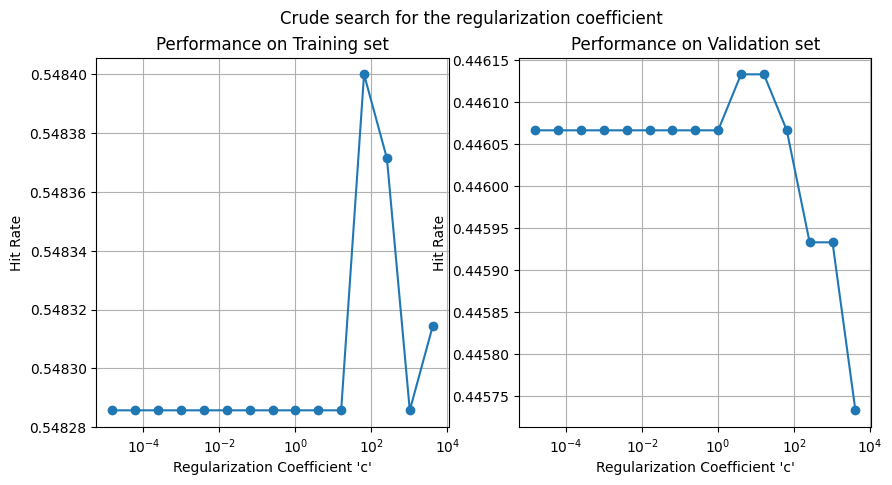

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


Testando com outros intervalos

In [45]:
c_values = [pow(2,d) for d in range(-10, 10, 2)]

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256


In [46]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256


Best c value: 4 
Performance of this value: 0.4461333333333333


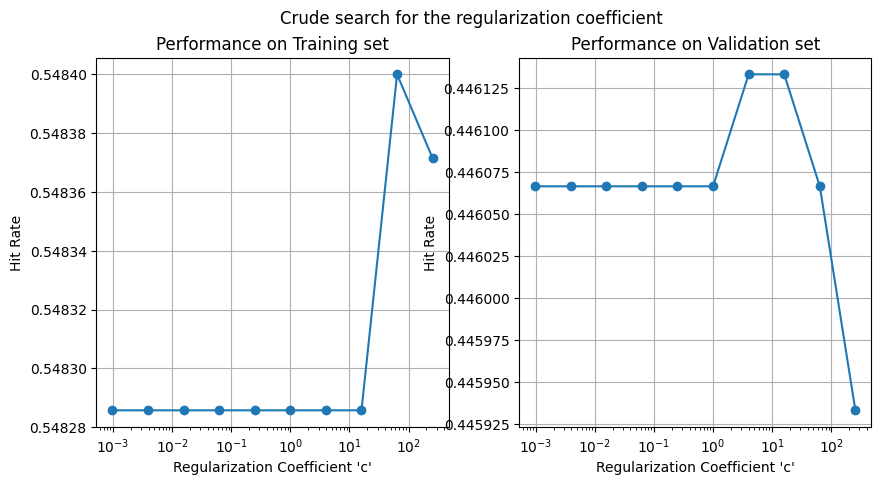

In [47]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Resposta da 3:** 

Analisando o notebook PC1_Ativ3_ELM_CIFAR.ipynb, é possível observar que o intervalo de excursão utilizado na busca em grade simplificada para os hiperparâmetros está relativamente amplo.

Por exemplo, para o número de neurônios na camada intermediária, o intervalo de busca varia de 100 a 5000. Esse intervalo é muito amplo, e pode levar a uma grande quantidade de modelos sendo testados, o que pode tornar o processo de busca muito demorado. Além disso, pode ser que alguns valores dentro desse intervalo não sejam adequados para a base de dados CIFAR-10, o que pode resultar em modelos com desempenho inferior.

O mesmo acontece com outros hiperparâmetros, como a função de ativação, que tem um intervalo de busca muito amplo, incluindo funções que podem não ser adequadas para a base de dados CIFAR-10.

Portanto, é possível que o intervalo de excursão utilizado na busca em grade simplificada para o CIFAR-10 não esteja adequado. É importante realizar uma análise mais aprofundada dos valores de hiperparâmetros que levam aos melhores resultados e ajustar os intervalos de busca de acordo com essas observações, a fim de tornar o processo de busca mais eficiente e encontrar a melhor combinação de hiperparâmetros para a base de dados CIFAR-10.

Modificando de (-16, 14, 2) para (-10, 10, 2), é possível definir que indifere a importância das regularizações. Ambos os casos garantiram um pico com o mesmo C value e performance, de 4 e 0,446, respectivamente.



In [14]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

1.0
2.5
4.0
5.5
7.0
8.5
10.0
11.5
13.0
14.5
16.0


In [15]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

1.0
2.5
4.0
5.5
7.0
8.5
10.0
11.5
13.0
14.5
16.0


Best c value: 4.0 
Performance of this value: 0.4461333333333333


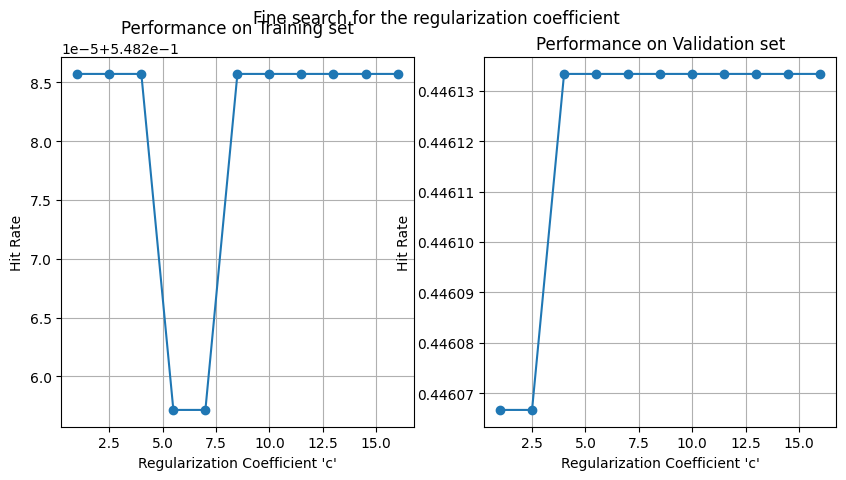

In [16]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [19]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(Xa.shape[0])])), Xa), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [21]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xta.shape[0])])), Xta), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
print(confusion_matrix)

Performance on test set: 0.457
[[539  40 115  45  71  38  18  42  96  41]
 [ 51 572  42  62  42  40  48  46  75 192]
 [ 44  10 288  68 142  91  76  41  11   9]
 [ 25  29  53 239  47 153  57  47  18  30]
 [ 19  11 107  46 336  58  79  64  15   6]
 [ 11  18  88 193  61 340  65  68  22  23]
 [ 23  29 118 146 122  99 551  39  14  37]
 [ 39  44  97  73 100  97  42 520  19  50]
 [182  77  52  49  45  41  25  40 669  96]
 [ 67 170  40  79  34  43  39  93  61 516]]
